# Setup

In [283]:
import kagglehub

install = False
if install:
    path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

    print("Path to dataset files:", path)

In [284]:
import pandas 
import os

# path to the dataset files so don't have to run above cell again
path = os.path.expanduser('~') +  "/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1"

# read data into dataframe
data_30_sec = pandas.read_csv(path + "/Data/features_30_sec.csv")
data_3_sec = pandas.read_csv(path + "/Data/features_3_sec.csv")

# Exploratory data analysis

In [285]:
# standard imports
import matplotlib.pyplot as plt
import seaborn as sb
import librosa
import numpy as np
plt.style.use('ggplot')

In [286]:
# missing data?
data_30_sec.head(10)
data_30_sec.describe()
data_30_sec.isnull().sum() # no missing data, data seems clean

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

## Basic plots with metadata 

Text(0.5, 1.0, 'Correlation between features')

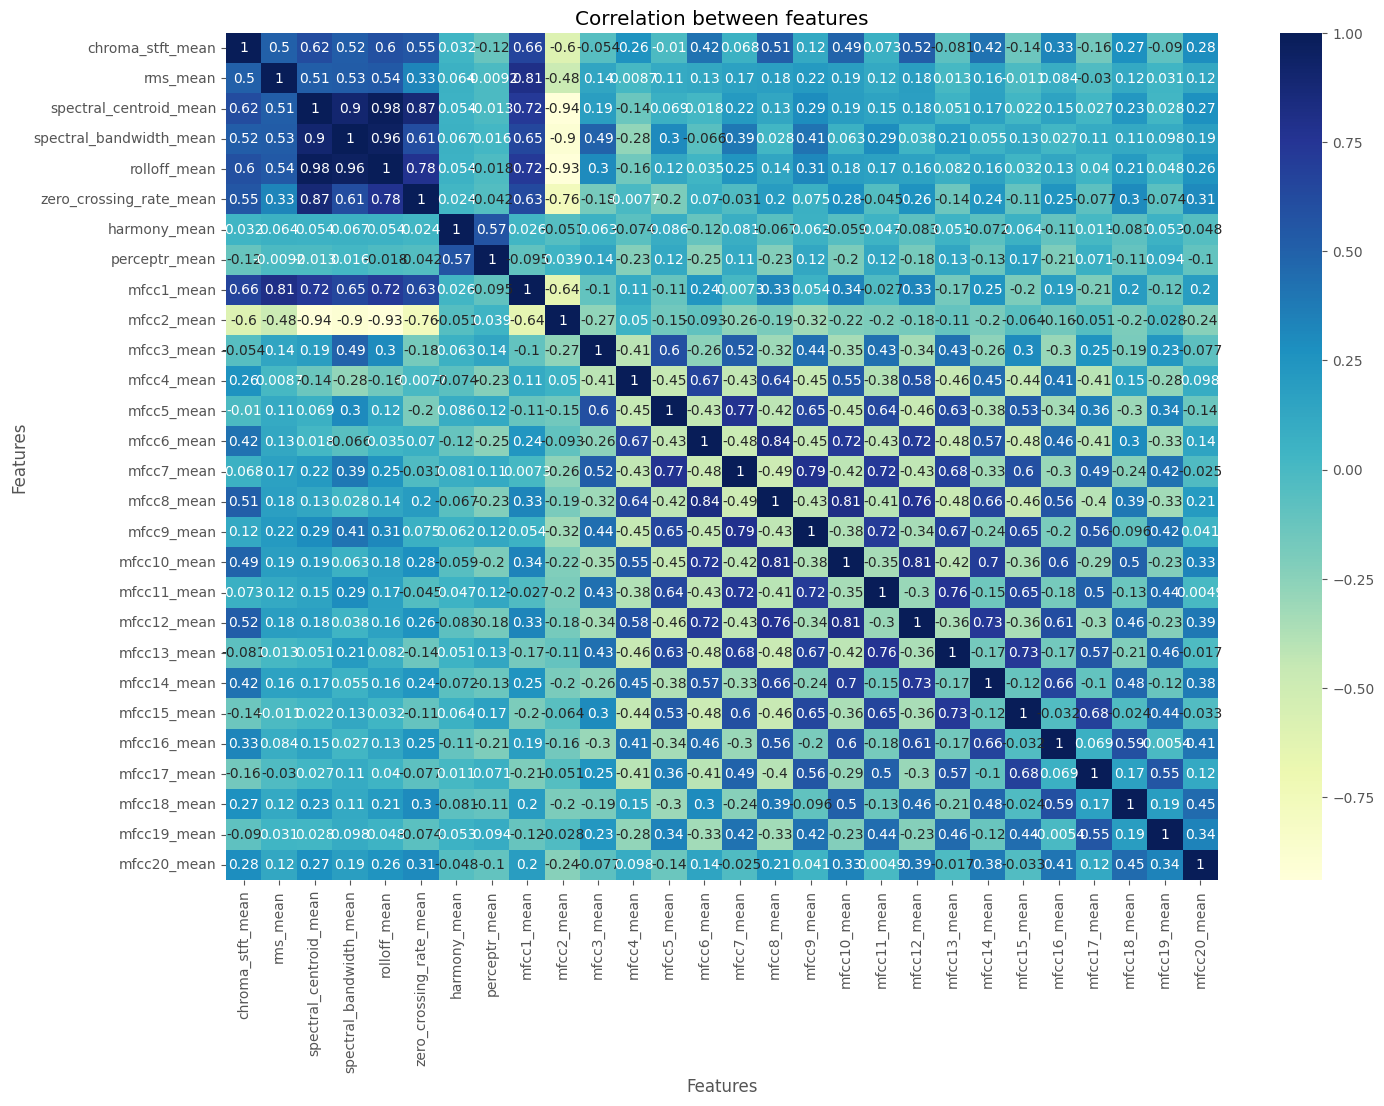

In [287]:
# Getting all the columns that have the mean data
mean_cols = [col for col in data_30_sec.columns if 'mean' in col]

fig, ax = plt.subplots(figsize=(16, 11));

dataplot = sb.heatmap(data_30_sec[mean_cols].corr(numeric_only=True), cmap="YlGnBu", annot=True)
ax.set_xlabel('Features')
ax.set_ylabel('Features')
ax.set_title('Correlation between features')
# There seems to be lots of moderately strong correlations between features, which should be useful in classification


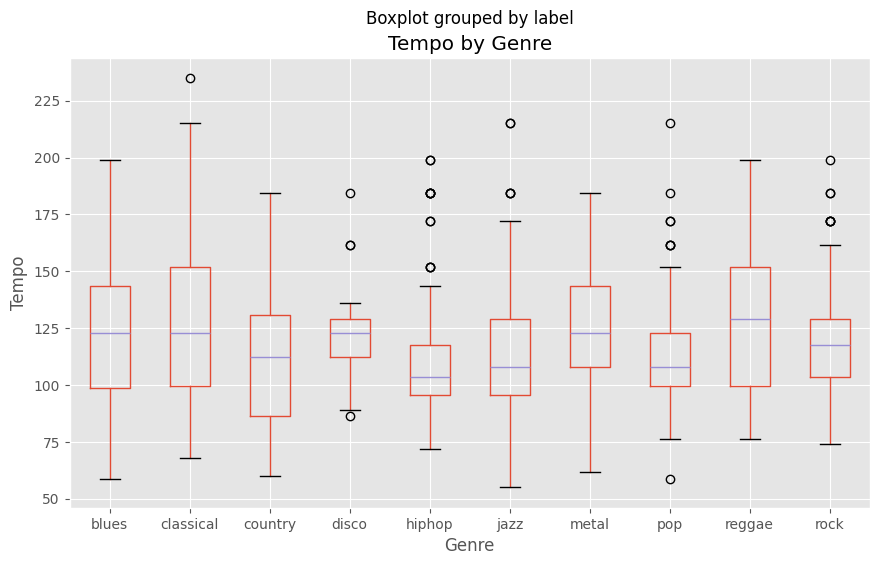

In [288]:
# plot tempo by genre
fig, ax = plt.subplots(figsize=(10, 6))
data_30_sec[['label', 'tempo']].boxplot(by = "label",ax=ax)
ax.set_title("Tempo by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Tempo")
plt.show()

# Tempo seems somewhat predictive of genre but there is a lot of overlap between genres

## Looking at the actual music data

In [289]:
# Create an array of all the songs
all_songs = {
    file:path + "/Data/genres_original/" + genre + "/" + file
        for genre in os.listdir(path + "/Data/genres_original") 
            if genre[0] != '.'
            for file in os.listdir(path + "/Data/genres_original/" + genre) 
                if file.endswith(".wav")
}

In [290]:
import random
import os

# Choose a random music file
music_data_path = path + "/Data/genres_original/"
genre = ''
while not genre:
    genre = random.choice(os.listdir(music_data_path))
    
    # Skip if we come across some kind of hidden file
    if (genre[0] == '.'):
        genre = ''

music_data_path += f'{genre}/'
music_data_path += random.choice(os.listdir(music_data_path))

x , sr = librosa.load(music_data_path)

### Waveplot

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050
country


Text(0.5, 1.0, 'Waveplot of the song from the country genre')

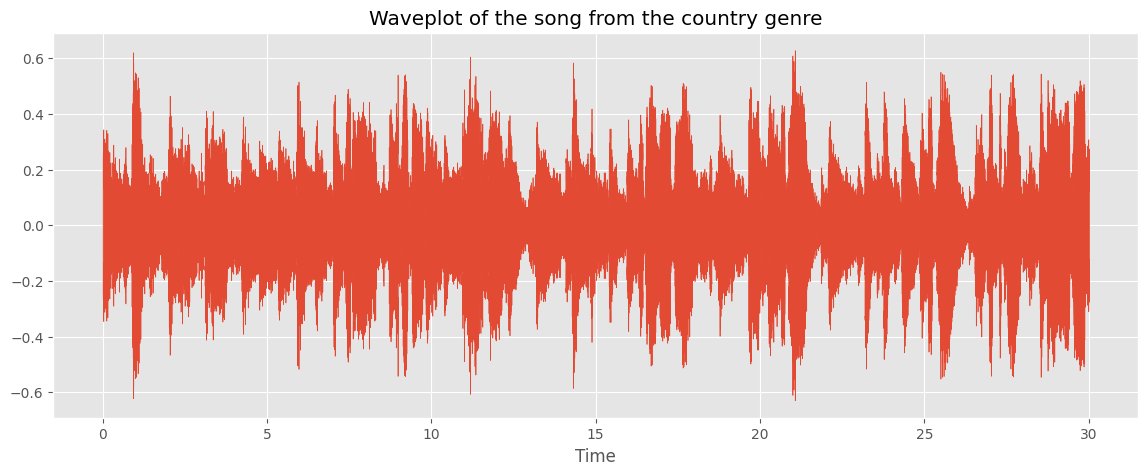

In [291]:
# the random song:
import IPython.display as ipd
import librosa.display

print(type(x), type(sr))
print(x.shape, sr)
print(genre)
ipd.Audio(x, rate=sr)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr) 
plt.title(f'Waveplot of the song from the {genre} genre')

### Spectrogram
#### Shows the variation in the sound frequencies in the song

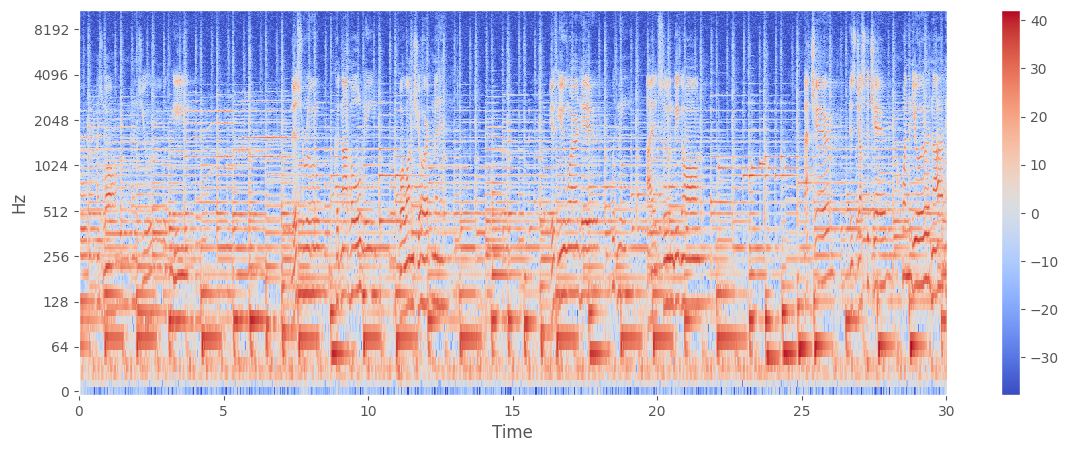

In [292]:
X = librosa.stft(x) # performs a fourier transform on the data
Xdb = librosa.amplitude_to_db(abs(X)) # converts the amplitude to decibels


# plotting
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Feature extraction 1: Zero crossing rate
#### The rate at which the signal changes from positive to negative, percussive music like metal and rock tend to have a higher zero crossing rate

1


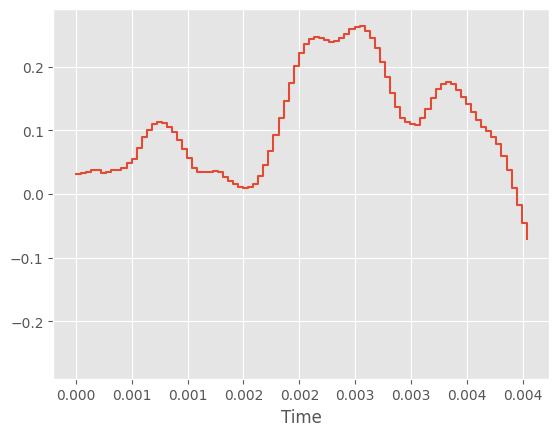

In [293]:
# Using a smaller window size so we can see what's happening
start = 10
end =  100
librosa.display.waveshow(x[start: end], sr=sr)

zero_crossings = librosa.zero_crossings(x[start:end], pad=False)
print(sum(zero_crossings)) # the signal crosses with the x-axis this many times

In [294]:
# Extract all the zero crossing rates from all songs
%pip install soundfile
import librosa
import soundfile as sf

zero_crossing_rates = {}

# process is too long to complete
if False:
    for name, path in all_songs.items():
        tempdata, tempsr = librosa.load(path)
        zero_crossings = librosa.zero_crossings(tempdata, pad=False)
        zero_crossing_rates[name] = sum(zero_crossings)

    print(zero_crossing_rates)

Note: you may need to restart the kernel to use updated packages.


### Feature extraction 2 : Spectral Centroid
#### The 'Centre of Mass' of a song. Where there is the weighted mean of the frequencies of a song

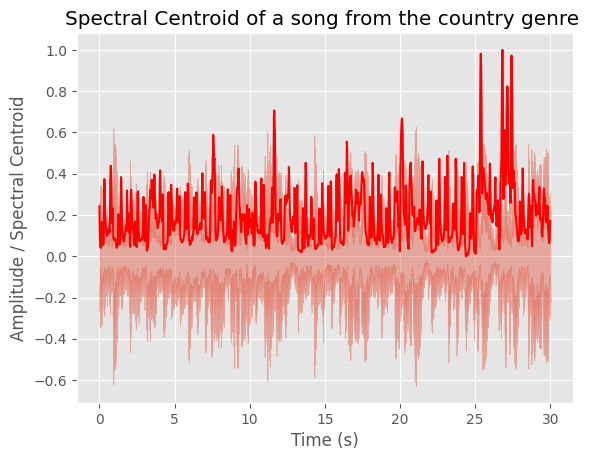

In [295]:
# This code is taken from the second article in 'README.md'
import sklearn

spectral_centroids = librosa.feature.spectral_centroid(y = x, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.title("Spectral Centroid of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude / Spectral Centroid')

# To listen to the song
ipd.Audio(x, rate=sr) 

### Feature extraction 3: Spectral Rolloff
#### Spectral rolloff is the frequency below which x % of the frequency lives. It is the upper bound frequency

Text(31.097222222222214, 0.5, 'Threshold')

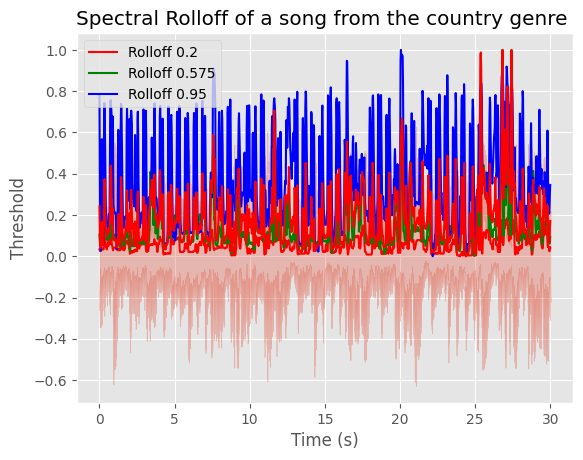

In [296]:


for perc, col in zip(np.linspace(start = 0.2, stop = 0.95, num = 3), ('r', 'g', 'b')):

    spec_rolloff = librosa.feature.spectral_rolloff(y = x, sr = sr, roll_percent = perc)[0]

    plt.plot(t, normalize(spec_rolloff), color = col)

librosa.display.waveshow(x, sr=sr, alpha=0.3)
plt.title("Spectral Rolloff of a song from the " + genre + " genre ")
plt.plot(t, normalize(spectral_centroids), color='r')
plt.xlabel('Time (s)')
plt.legend(['Rolloff 0.2', 'Rolloff 0.575', 'Rolloff 0.95'], loc='best')
plt.ylabel('Threshold')